In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from load_SAIdata import Cases
import interpolate

In [2]:
ds = Cases('hres.ref.1').select('atm','h0').open_mfdataset()

Reading combined kerchunk reference file /home/jasperdj/kerchunk/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12.001.cam2.h0.2002-12_2012-12.json


The highest 12 levels are pure pressure levels, below are 18 hybrid levels

In [3]:
ds.lev.size  # all hybrid model levels (pressure + sigma hybrid)

30

In [4]:
ds.lev.values[:12], ds.lev.values[12:]

(array([  3.64346569,   7.59481965,  14.35663225,  24.61222   ,
         38.26829977,  54.59547974,  72.01245055,  87.82123029,
        103.31712663, 121.54724076, 142.99403876, 168.22507977]),
 array([197.9080867 , 232.82861896, 273.91081676, 322.24190235,
        379.10090387, 445.9925741 , 524.68717471, 609.77869481,
        691.38943031, 763.40448111, 820.85836865, 859.53476653,
        887.02024892, 912.64454694, 936.19839847, 957.48547954,
        976.32540739, 992.55609512]))

In [5]:
# hybm is 0 for the first 12 model levels (sigma coordinate part)
(ds.hyam*1000).values[:12], ((ds.hyam+ds.hybm)*1000).values[12:]

(array([  3.64346569,   7.59481965,  14.35663225,  24.61222   ,
         38.26829977,  54.59547974,  72.01245055,  87.82123029,
        103.31712663, 121.54724076, 142.99403876, 168.22507977]),
 array([197.9080867 , 232.82861896, 273.91081676, 322.24190235,
        379.10090387, 445.9925741 , 524.68717471, 609.77869481,
        691.38943031, 763.40448111, 820.85836865, 859.53476653,
        887.02024892, 912.64454694, 936.19839847, 957.48547954,
        976.32540739, 992.55609512]))

When determining pressure levels to interpolate to, we wish to keep varying resolution with height and use round numbers to easily distill common pressure level maps. The 12 upper levels are taken without change. When increasing the resolution somewhat in the middle atmosphere, it is possible to get all vertical details at rounded pressure levels with only four extra levels (34 vs 30 hybrid levels).

In [6]:
plev = xr.DataArray(
    [*ds.lev[:12], 200,225,250,300,350,400,450,500,550,600,650,700,750,800,850,875,900,925,950,970,985,1000], 
    dims='plev',
    name='plev'
)
plev = plev.assign_coords(plev=plev.data)
plev

<xarray.DataArray 'plev' (plev: 34)> Size: 272B
array([   3.64346569,    7.59481965,   14.35663225,   24.61222   ,
         38.26829977,   54.59547974,   72.01245055,   87.82123029,
        103.31712663,  121.54724076,  142.99403876,  168.22507977,
        200.        ,  225.        ,  250.        ,  300.        ,
        350.        ,  400.        ,  450.        ,  500.        ,
        550.        ,  600.        ,  650.        ,  700.        ,
        750.        ,  800.        ,  850.        ,  875.        ,
        900.        ,  925.        ,  950.        ,  970.        ,
        985.        , 1000.        ])
Coordinates:
  * plev     (plev) float64 272B 3.643 7.595 14.36 24.61 ... 970.0 985.0 1e+03

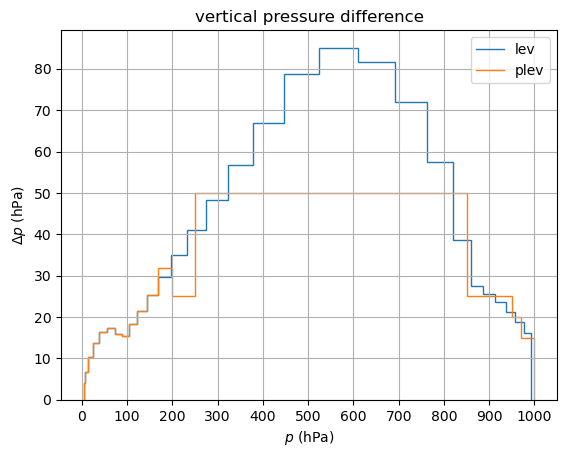

In [7]:
ax = plt.axes()
ax.stairs(ds.lev.diff('lev').data, ds.lev, label='lev')
ax.stairs(plev.diff('plev').data, plev, label='plev')
#plt.xscale('log')
ax.set_xticks(range(0,1001,100))
ax.legend()
ax.set_ylabel(r'$\Delta p$ (hPa)')
ax.set_xlabel(r'$p$ (hPa)')
ax.set_title('vertical pressure difference')
ax.grid()

In [8]:
print([float(p) for p in plev*100])  # print array to store in src/interpolate.py

[364.346569404006, 759.481964632869, 1435.6632251292501, 2461.22200042009, 3826.82997733355, 5459.54797416925, 7201.24505460262, 8782.123029232029, 10331.712663173701, 12154.7240763903, 14299.403876066199, 16822.5079774857, 20000.0, 22500.0, 25000.0, 30000.0, 35000.0, 40000.0, 45000.0, 50000.0, 55000.0, 60000.0, 65000.0, 70000.0, 75000.0, 80000.0, 85000.0, 87500.0, 90000.0, 92500.0, 95000.0, 97000.0, 98500.0, 100000.0]


In [9]:
print([float(p) for p in interpolate.PLEV])

[364.346569404006, 759.481964632869, 1435.6632251292501, 2461.22200042009, 3826.82997733355, 5459.54797416925, 7201.24505460262, 8782.123029232029, 10331.712663173701, 12154.7240763903, 14299.403876066199, 16822.5079774857, 20000.0, 22500.0, 25000.0, 30000.0, 35000.0, 40000.0, 45000.0, 50000.0, 55000.0, 60000.0, 65000.0, 70000.0, 75000.0, 80000.0, 85000.0, 87500.0, 90000.0, 92500.0, 95000.0, 97000.0, 98500.0, 100000.0]


In [10]:
P = interpolate.pressure_from_hybrid(ds).isel(time=0)
Ti = interpolate.interpolate(ds.T.isel(time=0), P/100, interpolate.PLEV/100, 'lev')
Tizm = Ti.mean('lon').compute()
Tzm = ds.T.isel(time=0).mean('lon').compute()

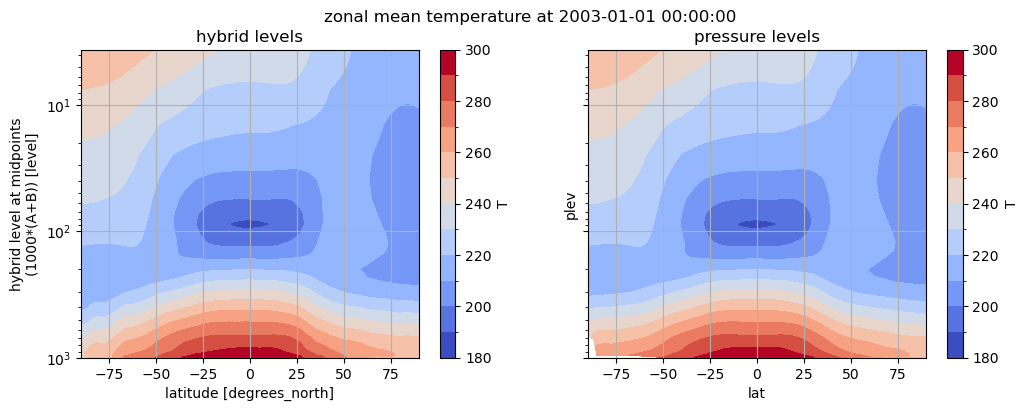

In [11]:
fig,axs = plt.subplots(1,2, figsize=(12,4), sharex=True, sharey=True)
Tzm.plot.contourf(ax=axs[0], y='lev', yincrease=False, yscale='log', cmap='coolwarm', levels=range(180,301,10))
Tizm.plot.contourf(ax=axs[1], y='plev', yincrease=False, yscale='log', cmap='coolwarm', levels=range(180,301,10))
axs[0].set_title('hybrid levels')
axs[1].set_title('pressure levels')
fig.suptitle(f'zonal mean temperature at {Tzm.time.item()}')
axs[0].grid()
axs[1].grid()